# 本ドキュメントについて

このドキュメントは、検証履歴の保存と整理を目的としています。

## Abstruct

Webマーケティングでは、ユーザーごとにアイテムを表示する最適化するレコメンデーションが実施されている。

2016年以降のいくつか研究が、Deep Learning(DL) を応用する事で表示するアイテムのクリック率が改善したと報告している。
さらにDLは複雑なデータでも柔軟に学習ができることから、ユーザーやアイテムの属性や日付などを情報を学習することで、より高い性能を発揮する事が期待されている。
例えば、適切に時間情報を学習に組み込む事がレコメンデーション性能が向上する事は以前の研究でも指摘されている。

本研究では、レコメンデーションにDLを適応する場合、時間情報の適切な学習方法を検討する。
[item, user, timestamp]を学習する　DLモデルをいくつか設計し、映画のレビュースコアデータでその性能を検証した。
その結果、時間情報を導入することでDLモデルの性能が?%した。
時間情報がなくとも、DLモデルはベースラインモデルであるMatrixFactorizationよりも?%高い性能を示した。

この検証から、DLを用いて様々な変数を学習することによってレコメンデーションを改善できる可能性を示した。


---

## 先行研究

2016年以降、いくつかの研究がディープラーニングを使ったレコメンデーションアルゴリズムについて言及しています。

特に研究が盛んなのは、クリック率予測問題の領域で、FNNやWide&Deepなどの手法が提案されています。

これらの先行手法では、Criteoが提供するWeb広告のクリック履歴データを用いて検証しており、(ユーザー, アイテム, 満足度スコア)の組み合わせ構造をもつ、アイテムレコメンデーションのデータでの検証はそれほどありません。

## 本研究の意義

これらの先行研究を参考にしつつ、アイテムレコメンデーションでのディープラーニングの応用を検証を行います。

この場合、なぜディープラーニングなのかについて整理を行います。

1. 既存の(ユーザー, アイテム)を、例えば(ユーザー, アイテム, 時間)のより高次元な組み合わせを扱えるようになります。
2. 転移学習により、学習済みの中間重みを別のレコメンデーションシステムに適応可能になり、総体としての改善が見込まれます。（中川さんのアイデア）
3. 

(1) については、特に「時間」を加味することは非常に有効であることが他の研究でもすでに指摘されており、多次元の組み合わせでレコメンデーションを行う有効性はすでに知られています。
また、2010年に提案された Factorization Machine(FM) は、理論的には多次元の組み合わせのレコメンデーションを計算できます。

一方で、高次元な組み合わせが疎データ問題をより悪化させ、性能に影響を与えることが懸念されています。
この問題の解決をディープラーニングで実現できるかが、本研究の要点の一つとなります。

(2)については、本来は研究を分けて行うべきだと思いますが、簡単に言及しておきます。
ディープラーニングでは、学習済みのweightを別の学習セットに転用する転移学習が盛んで、これが多くの分野で性能を発揮しています。
レコメンデーションはそのアプリケーションの特異性が強く、学習やモデルを調整する必要がありますが、転移学習を用いればそれを緩和できます。
画像判別や文章解析で実績の多い転移学習が、レコメンデーションでも有効なのかを検証するのも必要な研究でしょう。


## 以降から、

プログラムコードで、検証の過程を保存、整理していきます。


# コードを実行する前に

google colaboratery のメニュー「ランタイム」からpython3, GPUモードに切り替えてください。


In [0]:
# download this repository
!git clone --recurse-submodules https://github.com/uchida-takumi/thesis_20190715
# when cd directory, should use %.
%cd thesis_20190715


Cloning into 'thesis_20190715'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 154 (delta 81), reused 115 (delta 42), pack-reused 0
Receiving objects: 100% (154/154), 1.07 MiB | 9.41 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Submodule 'src/pyFM' (https://github.com/uchida-takumi/pyFM) registered for path 'src/pyFM'
Cloning into '/content/thesis_20190715/src/pyFM'...
remote: Enumerating objects: 5, done.        
remote: Counting objects: 100% (5/5), done.        
remote: Compressing objects: 100% (5/5), done.        
remote: Total 269 (delta 0), reused 3 (delta 0), pack-reused 264        
Receiving objects: 100% (269/269), 1.38 MiB | 10.21 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Submodule path 'src/pyFM': checked out '2e47265fffe3f029433333953a14977e357d2701'
/content/thesis_20190715


In [0]:
# setup module
!pip install -r requirements.txt
!pip install surprise
!pip install src/pyFM/
!pip uninstall -y tensorflow tensorflow-gpu
!pip install tensorflow-gpu==2.0.0-beta1

# download data
!mkdir data
%cd data
!curl -OL http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip
%cd ..

     |████████████████████████████████| 3.3MB 3.4MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.0.6-cp36-cp36m-linux_x86_64.whl size=1683520 sha256=17274510f3bea39cce278818fbeb4c4622454654bd81abef151bc8187914782a
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise
Processing ./src/pyFM
  Created wheel for pyfm: filename=pyfm-0.0.0-cp36-cp36m-linux_x86_64.whl size=221344 sha256=367991f44b363bfbb0a6e82cb517a0a07bd1b6068598aa281d74e64cefe1ef9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-a42fm687/wheels/1d/a4/09/df5064c3cb030c957d4d2eb611a67d6ac039930648de85b56c
Successfully built pyfm
Uninstalling tensorflow-1.14.0:
  Successfully uninstalled tensorflow-1.14.0
     |████████████████████████████████| 348.9MB 82kB/s 
     |████████████████████████████████| 501kB 48.3MB/s 
     |████████████████████████████████| 3.1MB 34.8MB/s 
/content/thesis_20190715/data
  % Total    % Re

In [1]:
# 学習中にWarningが発生するのでメッセージをオフにします。
import warnings
warnings.filterwarnings("ignore")


#######################
# 1. load data from src/modules/inputs.py
'''
ここで読み込んだデータは、MovieLensのショートデータです。
'''

import os
import pandas as pd
csv_fp = 'data/ml-latest-small/ratings.csv'
data = pd.read_csv(csv_fp)
column_names = ['userId', 'movieId', 'timestamp']
label_name = 'rating'

X, y = data[column_names].values, data[label_name].values

#　テストコーディング用
#X, y = X[:1000], y[:1000]


# レコメンデーションで扱うデータの種類について

大きな分類として、以下の構造的な違いがあります。

1. 表示したアイテムが全て観測され、どれがクリックの有無を含むデータ
2. クリックされたアイテムしか観測されないデータ

(1)のデータは広告、ニュース記事や検索結果リストのレコメンデーションで使われ、クリック率の改善を目的としたアルゴリズムが検討されます。この場合は強化学習がよく採用されているようです。（確証はない）

今回の研究で参考にしている Deep FM のアルゴリズムは、（1）に属している広告データである Criteo　のデータセットを使って研究されたものです。

一方で、上記でダウンロードした MovieLens のデータセットは(2)に属する映画の視聴レビューデータです。そのデータサンプルは、すでにユーザーが視聴をすることを決定した後に観測されたものとなります。

この(2)のタイプのデータはさらに２種類に分類できます。

- 2.1. implicit data 
- 2.2. explicit data

(2.1)はレビュースコア(rating)がないデータで、(2.2)はそれがあるデータです。
レビュースコアはユーザーのそのアイテムに対する満足度です。
それが明示されている場合はexplicitとなります。

これらのデータの違いによって、利用できるアルゴリズムが変わります。
(2.1)と(2.2)を複合するものもあり、SVD++などがそれに相当します。

今回、利用するデータは(2.1)のタイプです。

In [2]:
# X は [user, item, timestamp] です。
X

array([[         1,          1,  964982703],
       [         1,          3,  964981247],
       [         1,          6,  964982224],
       ...,
       [       610,     168250, 1494273047],
       [       610,     168252, 1493846352],
       [       610,     170875, 1493846415]])

In [3]:
# y は　　rating です。
y

array([4., 4., 4., ..., 5., 5., 3.])

# 手法のパラメータチューニング

検証する手法のパラメータチューニングを行います。
通常、　パラメータチューニングは、データセットをtrain,validation,testの３つに分類してtrain→validationでチューニングし、→testで評価を行います。

しかし、今回はパラメータチューニング専用のデータセットを用意し、train, validationの二分類だけでパラメータを確定させます。

その後、他のデータセットを用意し、train,testの二分類だけのCrossValidationを実施します。この時に、どのholdでも確定させたパラメータを統一して用います。


In [0]:
########################
# 2. define same interface of recommendater models
'''
ここでは、検証する手法のgrid-searchによるパラメータチューニングを行います。
用いるvalidation セットは、上述で読み込んだ X,y です。
train, test セットは別のデータを用いるとし、このデータでgrid-searchを行います。
'''
# 自作のgrid_search　モジュールを読み込みます。
from src.grid_search import grid_search

# グラフライブラリも読み込みます
%matplotlib inline
import matplotlib.pyplot as plt

# グラフ生成用の関数を定義しておきます。
import numpy as np

def grouped_bar_chart(datas, data_labels, xticklabels, ylabel='', xlabel='', title='', ylim=None):
  '''
  EXAMPLE
  ---------------
  xticklabels = ['G1', 'G2', 'G3', 'G4', 'G5']
  men_means = [20, 34, 30, 35, 27]
  women_means = [25, 32, 34, 20, 25]
  data_labels = ['men', 'women']
  ylim = (15, 40)

  grouped_bar_chart(datas=[men_means, women_means], data_labels, xticklabels, ylim=ylim)
  '''
  x = np.arange(len(xticklabels))  # the label locations
  n_datas = len(datas)
  width = 0.7/n_datas  # the width of the bars
  fig, ax = plt.subplots()
  rects = []
  for i,(data, label) in enumerate(zip(datas, data_labels)):
    pos = (x - 0.7/2) + i*width + width/2
    rects.append(ax.bar(pos, data, width, label=label))

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel(ylabel)
  ax.set_xlabel(xlabel)
  ax.set_title(title)
  ax.set_xticks(x)
  ax.set_xticklabels(xticklabels)
  #ax.set_xlim([xmin,xmax])
  ax.set_ylim(ylim)
  ax.legend()
  def autolabel(rects):
      """Attach a text label above each bar in *rects*, displaying its height."""
      for rect in rects:
          height = rect.get_height()
          ax.annotate('{}'.format(height),
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')
  for rect in rects:
    autolabel(rect)

  fig.tight_layout()
  plt.show()

In [0]:
#  BaseLine である MatrixFactorization　のパラメータチューニング
from surprise import SVD  
from src.surprise_algo_wrapper import surprise_algo_wrapper # I/F統一用のラッパー

model_module = SVD
wrapper = surprise_algo_wrapper

params = [
        {'n_factors':4,   'reg_all':0.010},
        {'n_factors':8,   'reg_all':0.010}, # the BEST
        {'n_factors':16,   'reg_all':0.010},
        {'n_factors':8,   'reg_all':0.001}, 
        {'n_factors':8,   'reg_all':0.100}, 
        ]
models = [wrapper(model_module(**param)) for param in params]
best_indice, scores, each_scores = grid_search(X, y, models)    
print('scores={}'.format(scores))
print('best_param={}'.format(params[best_indice]))
print('each_scores={}'.format(each_scores))

k_hold = 1/3
k_hold = 2/3
k_hold = 3/3
k_hold = 1/3
k_hold = 2/3
k_hold = 3/3
k_hold = 1/3
k_hold = 2/3
k_hold = 3/3
k_hold = 1/3
k_hold = 2/3
k_hold = 3/3
k_hold = 1/3
k_hold = 2/3
k_hold = 3/3
scores=[0.4923993327850942, 0.49091919831733594, 0.4795909309796626, 0.4862828228478249, 0.486081546830391]
best_param={'n_factors': 4, 'reg_all': 0.01}
each_scores=[[0.4892032762472077, 0.4968152866242038, 0.49117943548387094], [0.4854802680565897, 0.5003821656050955, 0.48689516129032256], [0.47083643584015883, 0.48305732484076436, 0.4848790322580645], [0.4844874658724249, 0.4945222929936306, 0.4798387096774194], [0.4753040456689005, 0.49554140127388535, 0.4873991935483871]]


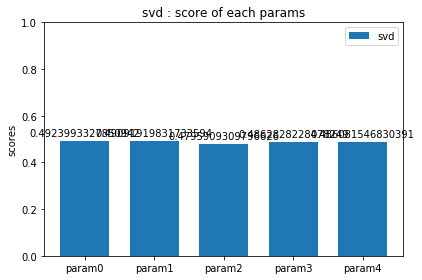

In [0]:
# pramasごとのグリットサーチのスコアを確認します。
grouped_bar_chart(
                  [scores],                   
                  data_labels=['svd'],
                  xticklabels=['param'+str(i) for i,p in enumerate(params)], 
                  title='svd',
                  ylabel='scores',
                  ylim=(0,1)
                  )

In [0]:
#  BaseLine である factorization machine　のパラメータチューニング
from pyfm.pylibfm import FM # factorization machine
from src.pyfm_model_wrapper import pyfm_model_wrapper # I/F統一用のラッパー

model_module = FM
wrapper = pyfm_model_wrapper

'''
    num_factors : int # 大きすぎると、python kernelが原因不明のシャットダウンを起こす？
        The dimensionality of the factorized 2-way interactions
    num_iter : int
        Number of iterations
    init_stdev : double, optional
        Standard deviation for initialization of 2-way factors.
        Defaults to 0.01.
    validation_size : double, optional # ここを0にしているとシャットダウンしやすい？
        Proportion of the training set to use for validation.
        Defaults to 0.01.
    task : string
        regression: Labels are real values.
        classification: Labels are either positive or negative.
    seed : int
        The seed of the pseudo random number generator
    reg_0 : float [注：自分でライブラリを改造して追加] 
        The regularization parameter of w0
    reg_w : float [注：自分でライブラリを改造して追加]
        The regularization parameter of w
    reg_v : float [注：自分でライブラリを改造して追加]
        The regularization parameter of each element in v

'''

params = [
        {'num_factors':4, 'num_iter':2, 'reg_0':0.0, 'reg_w':0.10, 'reg_v':0.010, 'validation_size':0.01, 'task':'regression'}, 
        {'num_factors':8, 'num_iter':2, 'reg_0':0.0, 'reg_w':0.10, 'reg_v':0.010, 'validation_size':0.01, 'task':'regression'}, 
        {'num_factors':16, 'num_iter':2, 'reg_0':0.0, 'reg_w':0.10, 'reg_v':0.010, 'validation_size':0.01, 'task':'regression'}, 
        {'num_factors':8, 'num_iter':2, 'reg_0':0.0, 'reg_w':0.10, 'reg_v':0.001, 'validation_size':0.01, 'task':'regression'}, 
        {'num_factors':8, 'num_iter':2, 'reg_0':0.0, 'reg_w':0.10, 'reg_v':0.100, 'validation_size':0.01, 'task':'regression'}, 
]
models = [wrapper(model_module(**param)) for param in params]
best_indice, scores, each_scores = grid_search(X, y, models)
print('scores={}'.format(scores))
print('best_param={}'.format(params[best_indice]))
print('each_scores={}'.format(each_scores))


k_hold = 1/3
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.43855
-- Epoch 2
Training MSE: 0.38921
k_hold = 2/3
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.43771
-- Epoch 2
Training MSE: 0.38754
k_hold = 3/3
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.43935
-- Epoch 2
Training MSE: 0.38985
k_hold = 1/3
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.43862
-- Epoch 2
Training MSE: 0.38818
k_hold = 2/3
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.43865
-- Epoch 2
Training MSE: 0.38714
k_hold = 3/3
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.43994
-- Epoch 2
Training MSE: 0.38859
k_hold = 1/3
Creating validation dataset of 0.01 of training for adapt

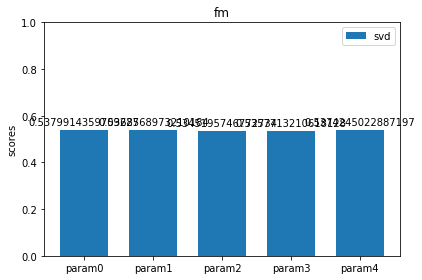

In [0]:
# pramasごとのグリットサーチのスコアを確認します。
grouped_bar_chart(
                  [scores],                   
                  data_labels=['fm'],
                  xticklabels=['param'+str(i) for i,p in enumerate(params)], 
                  title='fm',
                  ylabel='scores',
                  ylim=(0,1)
                  )

In [0]:
#  FNN のパラメータチューニング
from src.DNN_recommender import FNN # FNN
from src.keras_model_wrapper import keras_model_wrapper # I/F統一用のラッパー

model_module = FNN
wrapper = keras_model_wrapper

'''
    max_user [int]:
        max id number of user.
    max_item [int]:
        max id number of item.
    fix_global_bias [int or None]:
        fix global_bias as inputted int. if None, trained global_bias as weight.
    embedding_size [int]:
        latent factor number.
    dnn_hidden_units [array]:
        hidden layer size. (ex.) dnn_hidden_units=(62, 128, 62)
    l2_reg [float]:
        L2 reguralization.
'''
max_user, max_item = X[:,0].max()+1, X[:,1].max()+1

params = [
    {'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64), 'l2_reg':0.01},
    {'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64,64), 'l2_reg':0.01},
    {'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64,64,64), 'l2_reg':0.01},
    {'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64), 'l2_reg':0.10},
    {'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64), '
    ':0.001},
]
models = [wrapper(model_module, param, epochs=5, batch_size=124) for param in params]
best_indice, scores, each_scores = grid_search(X, y, models)    
print('scores={}'.format(scores))
print('best_param={}'.format(params[best_indice]))
print('each_scores={}'.format(each_scores))


k_hold = 1/3
Train on 70586 samples
Epoch 1/5
70586/70586 [==============================] - 7s 100us/sample - loss: 3.0994
Epoch 2/5
70586/70586 [==============================] - 7s 97us/sample - loss: 1.1067
Epoch 3/5
70586/70586 [==============================] - 7s 96us/sample - loss: 1.0216
Epoch 4/5
70586/70586 [==============================] - 7s 96us/sample - loss: 1.0070
Epoch 5/5
70586/70586 [==============================] - 7s 96us/sample - loss: 1.0044
k_hold = 2/3
Train on 70586 samples
Epoch 1/5
70586/70586 [==============================] - 7s 95us/sample - loss: 3.0891
Epoch 2/5
70586/70586 [==============================] - 7s 92us/sample - loss: 1.1068
Epoch 3/5
70586/70586 [==============================] - 6s 92us/sample - loss: 1.0218
Epoch 4/5
70586/70586 [==============================] - 6s 92us/sample - loss: 1.0065
Epoch 5/5
70586/70586 [==============================] - 7s 93us/sample - loss: 1.0048
k_hold = 3/3
Train on 70586 samples
Epoch 1/5
70586/70586

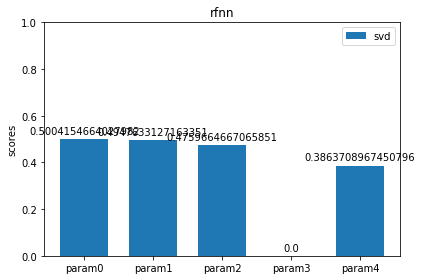

In [0]:
# pramasごとのグリットサーチのスコアを確認します。
grouped_bar_chart(
                  [scores],                   
                  data_labels=['FNN'],
                  xticklabels=['param'+str(i) for i,p in enumerate(params)], 
                  title='FNN',
                  ylabel='scores',
                  ylim=(0,1)
                  )

In [0]:
#  Wide&Deep のパラメータチューニング
from src.DNN_recommender import Wide_and_Deep # FNN
from src.keras_model_wrapper import keras_model_wrapper # I/F統一用のラッパー

model_module = Wide_and_Deep
wrapper = keras_model_wrapper

'''
    max_user [int]:
        max id number of user.
    max_item [int]:
        max id number of item.
    fix_global_bias [int or None]:
        fix global_bias as inputted int. if None, trained global_bias as weight.
    embedding_size [int]:
        latent factor number.
    dnn_hidden_units [array]:
        hidden layer size. (ex.) dnn_hidden_units=(62, 128, 62)
    l2_reg [float]:
        L2 reguralization.
'''
max_user, max_item = X[:,0].max()+1, X[:,1].max()+1

params = [
    {'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64), 'l2_reg':0.01},
    {'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64,64), 'l2_reg':0.01},
    {'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64,64,64), 'l2_reg':0.01},
    {'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64), 'l2_reg':0.10},
    {'max_user':max_user, 'max_item':max_item, 'embedding_size':8, 'dnn_hidden_units':(64), 'l2_reg':0.001},
]
models = [wrapper(model_module, param, epochs=5, batch_size=124) for param in params]
best_indice, scores, each_scores = grid_search(X, y, models, k_hold=1)    
print('scores={}'.format(scores))
print('best_param={}'.format(params[best_indice]))
print('each_scores={}'.format(each_scores))



k_hold = 1/1
Train on 70586 samples
Epoch 1/5
70586/70586 [==============================] - 8s 118us/sample - loss: 3.0327
Epoch 2/5
70586/70586 [==============================] - 8s 113us/sample - loss: 1.0875
Epoch 3/5
70586/70586 [==============================] - 8s 112us/sample - loss: 1.0175
Epoch 4/5
70586/70586 [==============================] - 8s 113us/sample - loss: 1.0063
Epoch 5/5
70586/70586 [==============================] - 8s 113us/sample - loss: 1.0059
k_hold = 1/1
Train on 70586 samples
Epoch 1/5
70586/70586 [==============================] - 8s 119us/sample - loss: 2.1730
Epoch 2/5
70586/70586 [==============================] - 8s 113us/sample - loss: 1.0354
Epoch 3/5
70586/70586 [==============================] - 8s 112us/sample - loss: 0.9957
Epoch 4/5
70586/70586 [==============================] - 8s 114us/sample - loss: 0.9879
Epoch 5/5
70586/70586 [==============================] - 8s 113us/sample - loss: 0.9873
k_hold = 1/1
Train on 70586 samples
Epoch 1/5
70

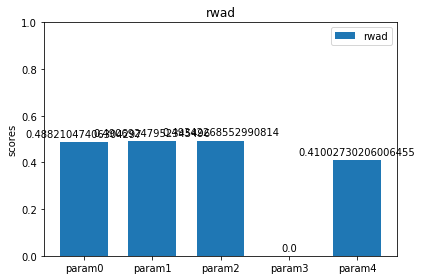

In [0]:
# pramasごとのグリットサーチのスコアを確認します。
grouped_bar_chart(
                  [scores],                   
                  data_labels=['wad'],
                  xticklabels=['param'+str(i) for i,p in enumerate(params)], 
                  title='wad',
                  ylabel='scores',
                  ylim=(0,1)
                  )

In [0]:
########################################
# それぞれが最適化したパラメータで、各モデルの性能比較を行う。

# モデルを読み込み
from src.control_model import random_model, popular_model
from surprise import SVD  # matrix factorization
from pyfm.pylibfm import FM # factorization machine
from src.DNN_recommender import FNN 
from src.DNN_recommender import Wide_and_Deep 

# I/F統一用のラッパー
from src.surprise_algo_wrapper import surprise_algo_wrapper 
from src.pyfm_model_wrapper import pyfm_model_wrapper
from src.keras_model_wrapper import keras_model_wrapper 

max_user, max_item = X[:,0].max()+1, X[:,1].max()+1

# 以下がグリッドサーチによってチューニングされた変数とする。
best_models = {
    "random" : random_model() ,
    "popular" : popular_model(),
    "svd" : surprise_algo_wrapper(SVD(n_factors=8,  reg_all=0.01)),
    "fm"  : pyfm_model_wrapper(FM(num_factors=8, num_iter=5, reg_0=0.0, reg_w=0.01, reg_v=0.01, validation_size=0.01, task='regression')),
    "FNN" : keras_model_wrapper(FNN, dict(max_user=max_user, max_item=max_item, embedding_size=8, dnn_hidden_units=(64), l2_reg=0.01)),
    "wad" : keras_model_wrapper(Wide_and_Deep, dict(max_user=max_user, max_item=max_item, embedding_size=8, dnn_hidden_units=(64), l2_reg=0.01)),
}

# それぞれのクロスバリデーションの結果を取得する。
from src.evaluation import cv
k_hold = 5
results = {'total_mean':[], 'metrics_by_labeled_user':[], 'metrics_by_labeled_item':[], 'metrics_by_labeled_user_item':[]}

for name, model in best_models.items():
    print(f"==== {name} ===")
    _result = cv(model, X, y, k_hold=k_hold, need_hit=True, seed=999)
    
    # result of total_mean
    _dict = {k:v for k,v in _result['total_mean'].items() if k not in results}
    _df = pd.DataFrame(_dict, index=[1])
    _df['model'] = name
    results['total_mean'].append(_df)
    
    # result of metrics_by_labeled_*
    for key in [key for key in results if key not in ('total_mean')]:
        _df = _result['total_mean'][key]
        _df['model'] = name
        results[key].append(_df)

==== FNN ===
k_hold = 1/5
Train on 70586 samples
Epoch 1/5
70586/70586 [==============================] - 8s 111us/sample - loss: 3.0155
Epoch 2/5
70586/70586 [==============================] - 7s 98us/sample - loss: 1.0945
Epoch 3/5
70586/70586 [==============================] - 7s 98us/sample - loss: 1.0192
Epoch 4/5
70586/70586 [==============================] - 7s 97us/sample - loss: 1.0069
Epoch 5/5
70586/70586 [==============================] - 7s 97us/sample - loss: 1.0049
k_hold = 2/5
Train on 70586 samples
Epoch 1/5
70586/70586 [==============================] - 7s 101us/sample - loss: 2.8245
Epoch 2/5
70586/70586 [==============================] - 7s 96us/sample - loss: 1.0779
Epoch 3/5
70586/70586 [==============================] - 7s 97us/sample - loss: 1.0167
Epoch 4/5
70586/70586 [==============================] - 7s 97us/sample - loss: 1.0055
Epoch 5/5
70586/70586 [==============================] - 7s 98us/sample - loss: 1.0042
k_hold = 3/5
Train on 70586 samples
Epoch 1

In [0]:
# cross validation の結果をresults_dfに整理して、pickleとして保存する。
results_df = {}
for name, df_list in results.items():
    results_df[name] = pd.concat(df_list, axis=0)

# pickle として保存しておく。
import pickle
with open('output/results_df.pickle', 'wb') as f:
    pickle.dump(results_df, f)

print('以下の結果が、results_dfには格納されている。')    
print(results_df.keys())

# 例えば、itemのsparse度合いごとの精度は以下の通りである。
results_df['metrics_by_labeled_item']

以下の結果が、results_dfには格納されている。
dict_keys(['total_mean', 'metrics_by_labeled_user', 'metrics_by_labeled_item', 'metrics_by_labeled_user_item'])


,abs_error,hit_top_5,hit_top_10,hit_top_20,hit_top_30,hit_top_40,hit_top_50,hit_top_100,n_sample,model
labeled_item,,,,,,,,,,
"000_(0.0, 0.0)",1.478892,0.005813,0.009634,0.019635,0.027905,0.039546,0.048369,0.101407,7378.6,random
"001_(0.0, 10.0]",1.489238,0.004561,0.008897,0.018949,0.030254,0.039215,0.048178,0.096844,14535.0,random
"002_(10.0, 20.0]",1.504947,0.007122,0.014648,0.025702,0.035321,0.047201,0.056004,0.105461,3157.0,random
"003_(20.0, 30.0]",1.530517,0.003030,0.009746,0.020410,0.030430,0.041167,0.051120,0.104941,1807.6,random
"004_(30.0, 40.0]",1.506425,0.005075,0.009346,0.019306,0.025195,0.037061,0.051639,0.102092,1103.6,random
"005_(40.0, 50.0]",1.522377,0.005777,0.014975,0.022794,0.037931,0.061385,0.075630,0.132244,635.6,random
"006_(50.0, inf]",1.528199,0.005674,0.007921,0.019139,0.029193,0.037334,0.046085,0.097632,1632.6,random
"000_(0.0, 0.0)",1.067118,0.000000,0.006226,0.051836,0.134094,0.218701,0.261904,0.464975,7378.6,popular
"001_(0.0, 10.0]",1.179187,0.083216,0.180353,0.317738,0.437431,0.506073,0.538934,0.694455,14535.0,popular


In [0]:
# visualizationを行う。
%matplotlib inline
import matplotlib.pyplot as plt

def plot_bar(a='metrics_by_labeled_item', b='hit_top_50', c=['labeled_item', 'model']):
    _df = results_df[a].reset_index()
    _df = _df.set_index(c)
    _df[b].plot(kind='bar')    

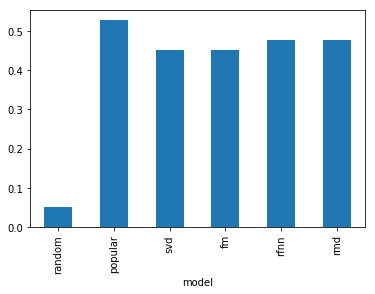

In [0]:
plot_bar(a='total_mean', b='hit_top_50_precision', c=['model'])

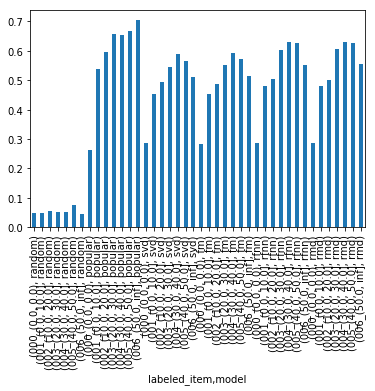

In [0]:
plot_bar(a='metrics_by_labeled_item', b='hit_top_50', c=['labeled_item', 'model'])

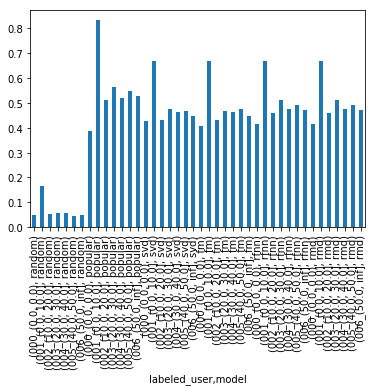

In [0]:
plot_bar(a='metrics_by_labeled_user', b='hit_top_50', c=['labeled_user', 'model'])

# ここでは、FNNとWide&Deepの学習効率の違いを確認します。

この二つのモデルの違いはWideパートの有無です。FNNとDeepパートは同じ構造になっています。

Wideパートは、MatrixFactorizationの数式モデルのアイテムとユーザーのIDバイアス項に相当すると考えることができます。これにより、IDレコメンデーションの問題においてWide&DeepはFNNよりも効率的に最適解に収束するのではないかと考えられます。

これを確認するために、train, test のloss scoreの推移を確認します。

ただし、ここでのscoreはloss関数に指定したratingの誤差となります。
これはグラフの生成にkeras のhistoryデータを応用しているせいです。
本来は、n-topリスト内に適切なアイテムIDを提案できたかのrankを確認すべきです。

In [18]:
##############################
# モデルを学習します

# モデルの読み込み
import numpy as np
from src.DNN_recommender import FNN 
from src.DNN_recommender import Wide_and_Deep 

# I/F統一用のラッパー
from src.keras_model_wrapper import keras_model_wrapper 

max_user, max_item = X[:,0].max()+1, X[:,1].max()+1


fnn = keras_model_wrapper(FNN, 
                          dict(max_user=max_user, max_item=max_item, embedding_size=8, dnn_hidden_units=(64), l2_reg=0.01),
                          epochs=10)
wad = keras_model_wrapper(Wide_and_Deep, 
                          dict(max_user=max_user, max_item=max_item, embedding_size=8, dnn_hidden_units=(64), l2_reg=0.01), 
                         epochs=10)

# それぞれのクロスバリデーションの結果を取得する。
indices = np.random.permutation(X.shape[0])
train_size = int(X.shape[0] * 0.7)
X_train, y_train = X[indices[:train_size]], y[indices[:train_size]]
X_test, y_test = X[indices[train_size:]], y[indices[train_size:]]

fnn.fit(X_train, y_train, X_test, y_test)
wad.fit(X_train, y_train, X_test, y_test)

Train on 70585 samples, validate on 30251 samples
Epoch 1/10
70585/70585 [==============================] - 12s 165us/sample - loss: 3.0693 - val_loss: 1.1919
Epoch 2/10
70585/70585 [==============================] - 11s 159us/sample - loss: 1.0856 - val_loss: 1.0510
Epoch 3/10
70585/70585 [==============================] - 11s 156us/sample - loss: 1.0160 - val_loss: 1.0220
Epoch 4/10
70585/70585 [==============================] - 12s 163us/sample - loss: 1.0037 - val_loss: 1.0225
Epoch 5/10
70585/70585 [==============================] - 11s 155us/sample - loss: 1.0024 - val_loss: 1.0188
Epoch 6/10
70585/70585 [==============================] - 11s 161us/sample - loss: 1.0023 - val_loss: 1.0174
Epoch 7/10
70585/70585 [==============================] - 11s 155us/sample - loss: 1.0013 - val_loss: 1.0204
Epoch 8/10
70585/70585 [==============================] - 11s 161us/sample - loss: 1.0015 - val_loss: 1.0145
Epoch 9/10
70585/70585 [==============================] - 11s 160us/sample - l

{'loss': [3.0692597499639884,
          1.0856173228227848,
          1.0159876353706745,
          1.003727372599415,
          1.0023931890994198,
          1.00226958456159,
          1.001252261987867,
          1.0014837127599279,
          1.0002618353199821,
          0.9995440039172291],
 'val_loss': [1.1918714066181635,
              1.0510194609489982,
              1.022034399371743,
              1.0225429737699125,
              1.0188456461577844,
              1.0174351907762385,
              1.0204124885182164,
              1.014501484073823,
              1.0154282793475082,
              1.0187012379372251]}


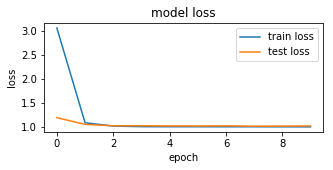

In [24]:
%matplotlib inline
from pprint import pprint
# FNN　の学習過程のスコア推移をグラフ化します。
from src import visualization
visualization.keras_model_wrapper_fit_history_chart(fnn, save_png_path='/tmp/fnn.png')

pprint(fnn.model.history.history)


{'loss': [3.0262285876546016,
          1.081645507906908,
          1.0150384794359395,
          1.0040112602294415,
          1.0027730546693774,
          1.002835818622946,
          1.0021773211517084,
          1.0019325177274496,
          1.001532236872951,
          1.0017855168875127],
 'val_loss': [1.185160253639911,
              1.0471974236721409,
              1.0261513966457307,
              1.0225605351807228,
              1.0192411256732596,
              1.0189801880649005,
              1.0197944169335946,
              1.0172502592253783,
              1.0229181928920894,
              1.0159402411932401]}


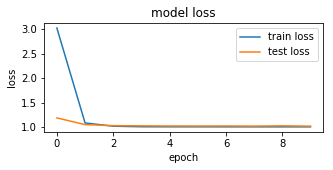

In [25]:
# Deep&Wide　の学習過程のスコア推移をグラフ化します。
from src import visualization
visualization.keras_model_wrapper_fit_history_chart(wad, save_png_path='/tmp/wad.png')

pprint(wad.model.history.history)


上の図のグラフでは学習効率の違いは判断できませんでした。
このデータセットでは、1epochでほぼ学習結果が収束していることが分かります。
なので、FNNだろうとDeep&Wideだろうと学習効率は同じだということが分かりました。

Wideパートによる学習効率の改善は、他のデータセットやその量によって有効となる可能性はあります。